# Monte Carlo control

We now try to extract a policy from the estimated action value function. One straightforward way is to use a policy iteration style algorithm, alternating between policy evaluation and policy extraction. However, a problem with this approach is that the estimated action value function may provide poor estimates for unexplored states. If we extract the policy greedily, we risk overlooking unexplored states that might offer higher rewards. To address this, we propose two modifications: Monte Carlo with exploring starts and Monte Carlo with a stochastic policy.

In [1]:
!pip -q install gym

import numpy as np
import matplotlib.pyplot as plt
import gym
import itertools
from MonteCarlo import *
import copy
import seaborn as sns

env = gym.make('Blackjack-v1', natural=False, sab=False)

player_sum_range = range(32)       
dealer_card_range = range(1, 11)   
usable_ace_range = [True, False]

states = list(itertools.product(player_sum_range, dealer_card_range, usable_ace_range))
actions = [0, 1]

state_action_dict = {state: int(state[0] < 20) for state in states}

class stick_at_20_or_21(Policy):
    def policy(self, state, epsilon=0.0):
        return self.state_action_dict[state]

## Monte Carlo with exploring starts

The first method, known as Monte Carlo with exploring starts, simply involves initializing the start state differently for each episode. The idea is to achieve better coverage of explored states. We implement the algorithm below. Note that, similar to policy iteration, we alternate between one step of policy evaluation and one step of policy improvement.

In [4]:
class MonteCarloControl:
    """
    Monte Carlo Control to estimate the optimal policy
    """
    def __init__(self, states: list, actions: list, policy: Policy):
        """ 
        @param states: A list of available states
        @param actions: A list of available actions
        @param policy: A Policy instance with sample implemented
        """
        self.states = states
        self.actions = actions
        self.policy = policy
        
    def estimate(self, env: any, max_iter: int, gamma:float=1, every_visit:bool=False):
        """ 
        Estimates the action value function and the optimal policy
        @return value: The estimated q-value fucntion of the form 
            {state1: value1,...}
        @return policy: The optimal policy function
        """
        value = {state: {action: 0 for action in self.actions} for state in self.states}
        count = {state: {action: 0 for action in self.actions} for state in self.states}
        for i in range(max_iter):
            episode = self.policy.sample(env)
            cum_reward = 0
            for t, (state_action, reward) in enumerate(list(episode.items())[::-1]):
                state, action = state_action
                t = len(episode) - t - 1
                cum_reward = gamma * cum_reward + reward
                if every_visit or state not in self.states[:t]:
                    count[state][action] += 1
                    value[state][action] = value[state][action] + (cum_reward - value[state][action]) / count[state][action]    
                    self.policy.state_action_dict[state] = max(value[state], key=value[state].get)
        return value, self.policy

We test the algorithm in the Blackjack environment, beginning with the same strategy as before. We run the algorithm for $5,000,000$ iterations. The resulting optimal policy is displayed below. We have separated the cases based on whether the player has a usable ace. For each case, given a state $(\text{player hand}, \text{dealer hand})$, the policy determines whether to perform the action "Hit" or "Stick." 

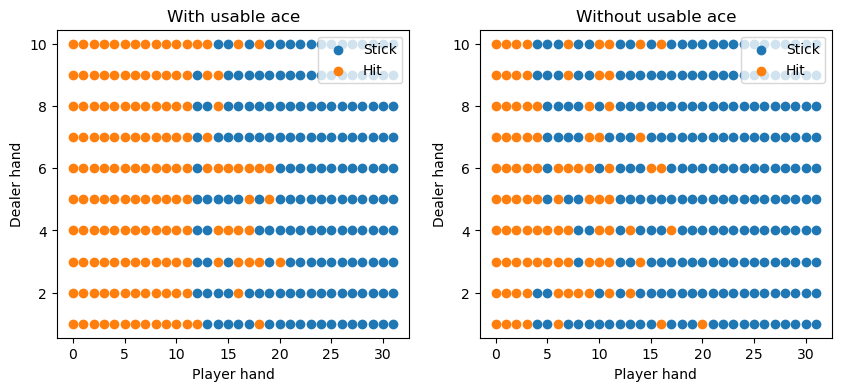

In [7]:
policy = stick_at_20_or_21(states, actions, state_action_dict)
mc = MonteCarloControl(states, actions, policy)
q_values, optimal_policy = mc.estimate(env, 5000000)
plotBlackJackOptimalStrategy(optimal_policy, states)

## Monte Carlo with stochastic policies

The first approach places a strong assumption on the environment: we are allowed to change the starting state in each episode. This may not be a realistic assumption in some settings. Another way to address this is to use a stochastic policy. Given a deterministic policy $\pi$, we define the $\epsilon$-greedy policy $\pi_{\epsilon}$ as

$$
\pi_{\epsilon}(\mathbf{s}|\mathbf{a}) = 
\begin{cases}
\pi(\mathbf{a}|\mathbf{s}) & \text{with probability } 1 - \epsilon \\
\text{random action} & \text{with probability } \epsilon
\end{cases}
$$

In this case, with some small probability, we take a random action, thereby increasing our chances of moving into a seemingly suboptimal and unexplored state, which helps in obtaining better action value estimates. We implement this method below.

In [8]:
class stick_at_20_or_21_stochastic(Policy):
    def policy(self, state, epsilon=0.10):
        if np.random.rand() < epsilon:
            return np.random.choice(self.actions)
        return self.state_action_dict[state]

We followed the $\epsilon$-greedy policy of the `stick_at_20_or_21` policy, with $\epsilon=0.1$. We ran the algorithm for $5000000$ iterations, the final result is shown below. Note that we get a much smoother decision boundary. This result is also consistent with the solutions shown online.

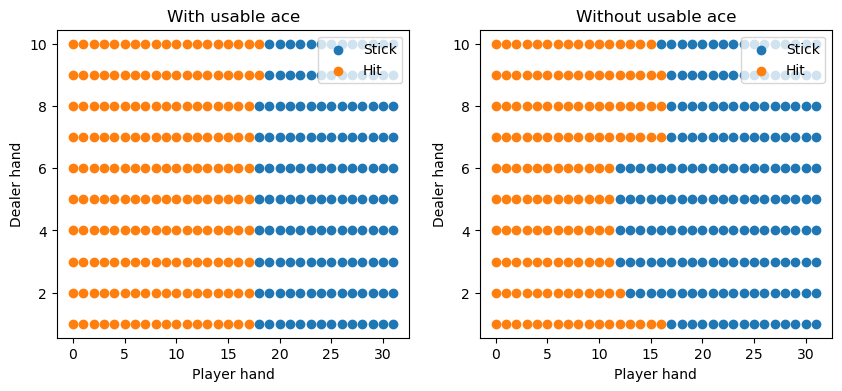

In [19]:
policy = stick_at_20_or_21_stochastic(states, actions, state_action_dict)
montecarlo = MonteCarloControl(states, actions, policy)
q_values, optimal_policy = montecarlo.estimate(env, 5000000)
plotBlackJackOptimalStrategy(optimal_policy, states, epsilon=0.0)

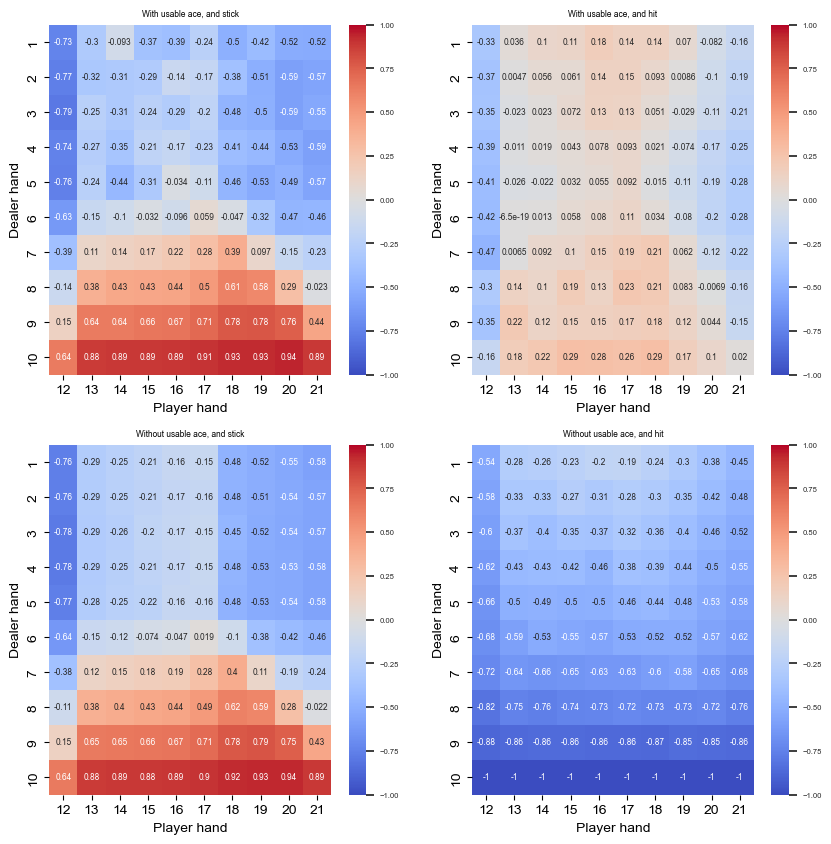

In [10]:
plot_q_values_heatmap(q_values)